# Reco efficiency study with signal MC

**gen muon pair in acceptance**
- both generated muon pT>25GeV
- both generated muon |eta|<2
- lxy<750cm

**gen darkphoton in acceptance**
- pT>50GeV
- |eta|<2
- lxy<750cm

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from awkward import JaggedArray
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
from FireHydrant.Tools.trigger import Triggers
import awkward

np.seterr(divide='ignore', invalid='ignore', over='ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from os.path import join
import os
import json
datasets_2mu2e = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2-1.json')))
datasets_4mu = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2-1.json')))
datasets = {'2mu2e':[], '4mu': []}
for k,v in datasets_2mu2e.items():
    if not k.endswith('lxy-300'):
        continue
    datasets['2mu2e'].extend(v)
for k,v in datasets_4mu.items():
    if not k.endswith('lxy-300'):
        continue
    datasets['4mu'].extend(v)

## 1. dSA reco efficiency vs. lxy, gen Mu in acceptance, w/ & w/o trigger requirement

In [3]:
class dsaEfficiency(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            vx=df['gen_vtx.fCoordinates.fX'].content,
            vy=df['gen_vtx.fCoordinates.fY'].content,
            vz=df['gen_vtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(rho=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.pt>25)&(np.abs(genparticles.eta)<2)&(genparticles.rho<750)]
        
        ## at least 2 good gen muons
        nmuGe2 = genmuons.counts>=2
        genmuons = genmuons[nmuGe2]
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            px=df['dsamuon_p4.fCoordinates.fX'].content,
            py=df['dsamuon_p4.fCoordinates.fY'].content,
            pz=df['dsamuon_p4.fCoordinates.fZ'].content,
            energy=df['dsamuon_p4.fCoordinates.fT'].content,
        )
        dsamuons = dsamuons[nmuGe2]
        
        foundreco = genmuons.match(dsamuons, deltaRCut=0.3)
        
        output['lxy'].fill(dataset=dataset, lxy=genmuons[foundreco].rho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=genmuons[~foundreco].rho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [4]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsaEfficiency(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:12<00:00,  8.30items/s]


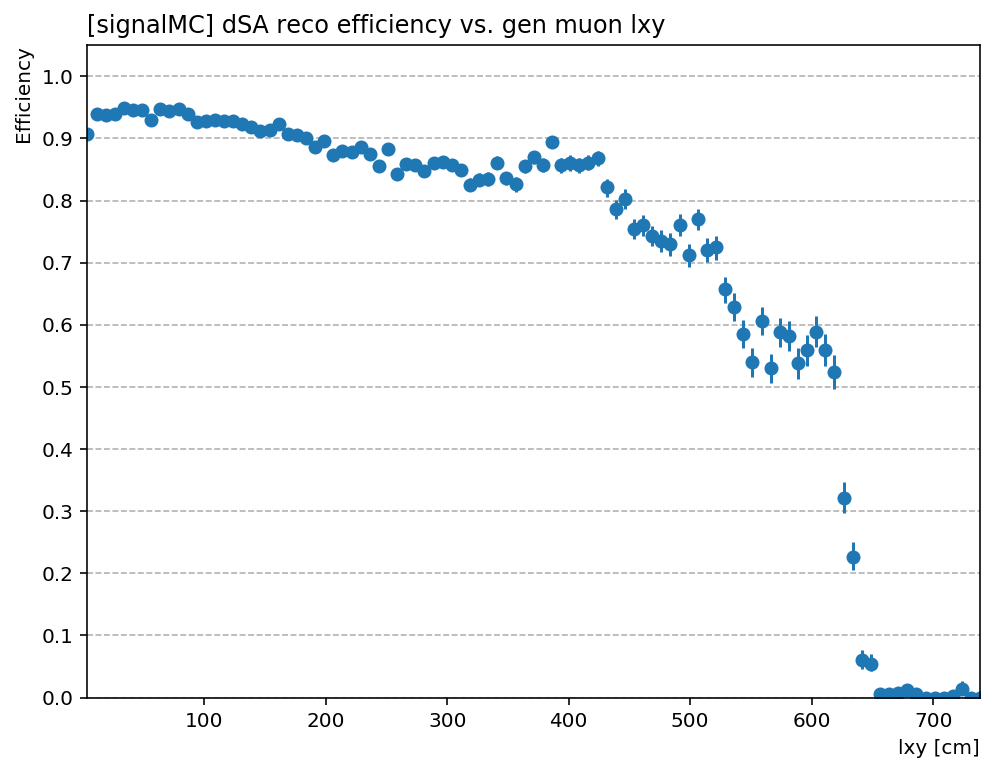

In [5]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] dSA reco efficiency vs. gen muon lxy', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

In [6]:
class dsaEfficiencyWithTrigger(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        trigger=np.logical_or.reduce([df[t] for t in Triggers])
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            vx=df['gen_vtx.fCoordinates.fX'].content,
            vy=df['gen_vtx.fCoordinates.fY'].content,
            vz=df['gen_vtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(rho=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.pt>25)&(np.abs(genparticles.eta)<2)&(genparticles.rho<750)]
        
        ## at least 2 good gen muons
        nmuGe2 = genmuons.counts>=2
        genmuons = genmuons[nmuGe2&trigger]
        
        dsamuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            px=df['dsamuon_p4.fCoordinates.fX'].content,
            py=df['dsamuon_p4.fCoordinates.fY'].content,
            pz=df['dsamuon_p4.fCoordinates.fZ'].content,
            energy=df['dsamuon_p4.fCoordinates.fT'].content,
        )
        dsamuons = dsamuons[nmuGe2&trigger]
        
        foundreco = genmuons.match(dsamuons, deltaRCut=0.3)
        
        output['lxy'].fill(dataset=dataset, lxy=genmuons[foundreco].rho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=genmuons[~foundreco].rho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [7]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=dsaEfficiencyWithTrigger(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:12<00:00,  8.29items/s]


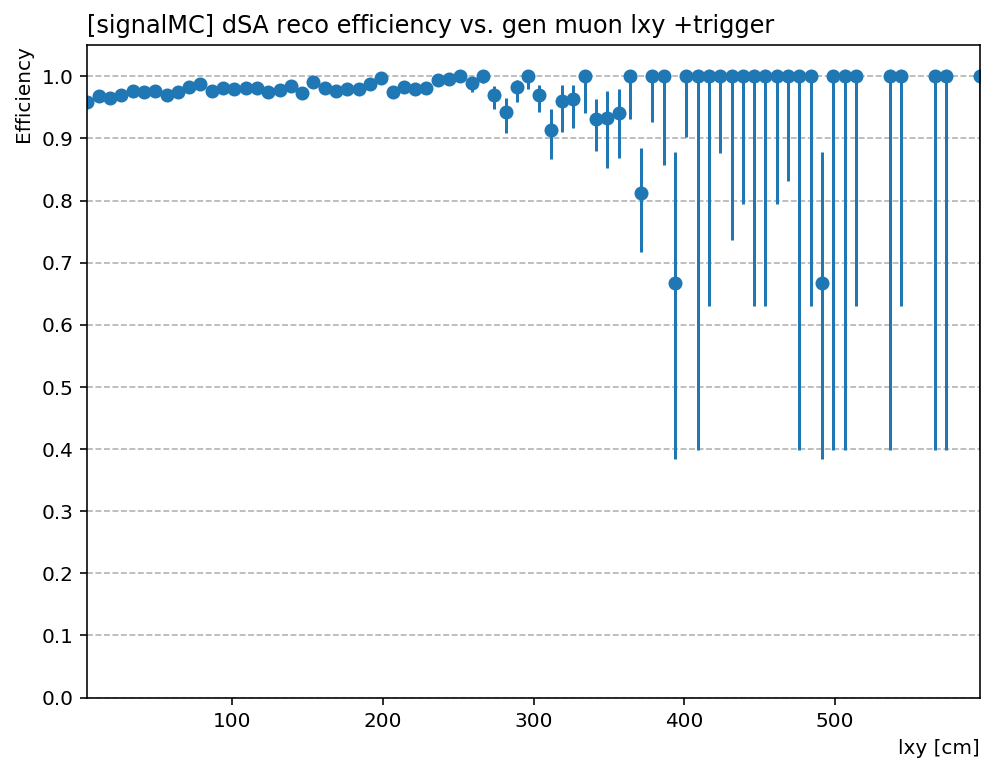

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] dSA reco efficiency vs. gen muon lxy +trigger', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

## 2. leptonjetSource Mu reco efficiency vs. lxy, gen Mu in acceptance, w/ & w/o trigger requirement

### 2.1 PFMu+dSAMu

In [9]:
class ljsrcEfficiency(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            vx=df['gen_vtx.fCoordinates.fX'].content,
            vy=df['gen_vtx.fCoordinates.fY'].content,
            vz=df['gen_vtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(rho=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.pt>25)&(np.abs(genparticles.eta)<2)&(genparticles.rho<750)]
        
        ## at least 2 good gen muons
        nmuGe2 = genmuons.counts>=2
        genmuons = genmuons[nmuGe2]
        
        ljsrcs = JaggedCandidateArray.candidatesfromcounts(
            df['ljsource_p4'],
            px=df['ljsource_p4.fCoordinates.fX'].content,
            py=df['ljsource_p4.fCoordinates.fY'].content,
            pz=df['ljsource_p4.fCoordinates.fZ'].content,
            energy=df['ljsource_p4.fCoordinates.fT'].content,
            pid=df['ljsource_type'].content,
        )
        ljsrcmu = ljsrcs[(ljsrcs.pid==3)|(ljsrcs.pid==8)]
        ljsrcmu = ljsrcmu[nmuGe2]
        
        foundreco = genmuons.match(ljsrcmu, deltaRCut=0.3)
        
        output['lxy'].fill(dataset=dataset, lxy=genmuons[foundreco].rho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=genmuons[~foundreco].rho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [10]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljsrcEfficiency(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:11<00:00,  9.05items/s]


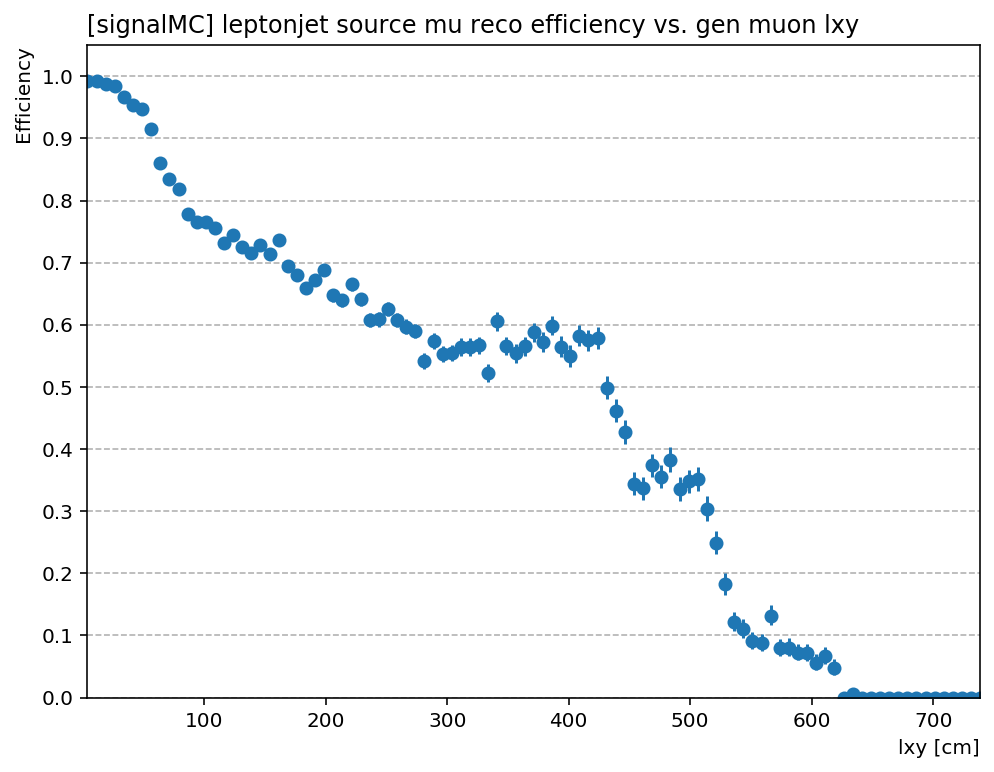

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] leptonjet source mu reco efficiency vs. gen muon lxy', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

In [12]:
class ljsrcEfficiencyWithTrigger(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        trigger=np.logical_or.reduce([df[t] for t in Triggers])
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            vx=df['gen_vtx.fCoordinates.fX'].content,
            vy=df['gen_vtx.fCoordinates.fY'].content,
            vz=df['gen_vtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(rho=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.pt>25)&(np.abs(genparticles.eta)<2)&(genparticles.rho<750)]
        
        ## at least 2 good gen muons
        nmuGe2 = genmuons.counts>=2
        genmuons = genmuons[nmuGe2&trigger]
        
        ljsrcs = JaggedCandidateArray.candidatesfromcounts(
            df['ljsource_p4'],
            px=df['ljsource_p4.fCoordinates.fX'].content,
            py=df['ljsource_p4.fCoordinates.fY'].content,
            pz=df['ljsource_p4.fCoordinates.fZ'].content,
            energy=df['ljsource_p4.fCoordinates.fT'].content,
            pid=df['ljsource_type'].content,
        )
        ljsrcmu = ljsrcs[(ljsrcs.pid==3)|(ljsrcs.pid==8)]
        ljsrcmu = ljsrcmu[nmuGe2&trigger]
        
        foundreco = genmuons.match(ljsrcmu, deltaRCut=0.3)
        
        output['lxy'].fill(dataset=dataset, lxy=genmuons[foundreco].rho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=genmuons[~foundreco].rho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [13]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljsrcEfficiencyWithTrigger(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:11<00:00,  9.05items/s]


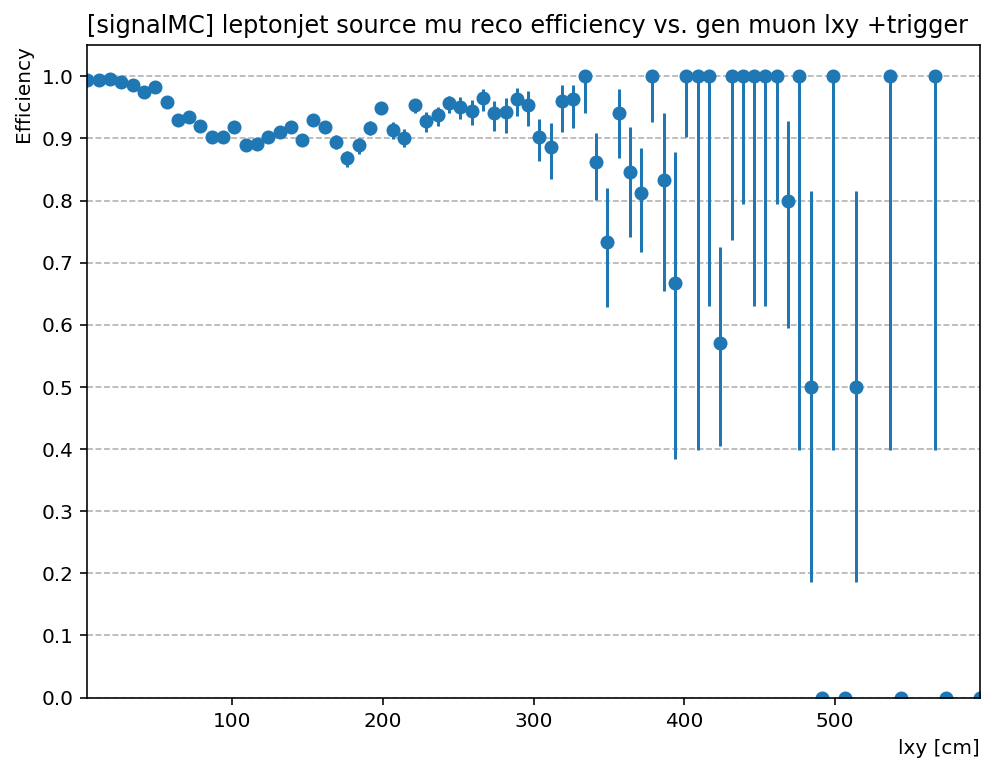

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] leptonjet source mu reco efficiency vs. gen muon lxy +trigger', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

### 2.2 dSAMu only

In [15]:
class ljsrcDsaEfficiency(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            vx=df['gen_vtx.fCoordinates.fX'].content,
            vy=df['gen_vtx.fCoordinates.fY'].content,
            vz=df['gen_vtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(rho=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.pt>25)&(np.abs(genparticles.eta)<2)&(genparticles.rho<750)]
        
        ## at least 2 good gen muons
        nmuGe2 = genmuons.counts>=2
        genmuons = genmuons[nmuGe2]
        
        ljsrcs = JaggedCandidateArray.candidatesfromcounts(
            df['ljsource_p4'],
            px=df['ljsource_p4.fCoordinates.fX'].content,
            py=df['ljsource_p4.fCoordinates.fY'].content,
            pz=df['ljsource_p4.fCoordinates.fZ'].content,
            energy=df['ljsource_p4.fCoordinates.fT'].content,
            pid=df['ljsource_type'].content,
        )
        ljsrcmu = ljsrcs[(ljsrcs.pid==8)]
        ljsrcmu = ljsrcmu[nmuGe2]
        
        foundreco = genmuons.match(ljsrcmu, deltaRCut=0.3)
        
        output['lxy'].fill(dataset=dataset, lxy=genmuons[foundreco].rho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=genmuons[~foundreco].rho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [16]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljsrcDsaEfficiency(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:10<00:00,  9.95items/s]


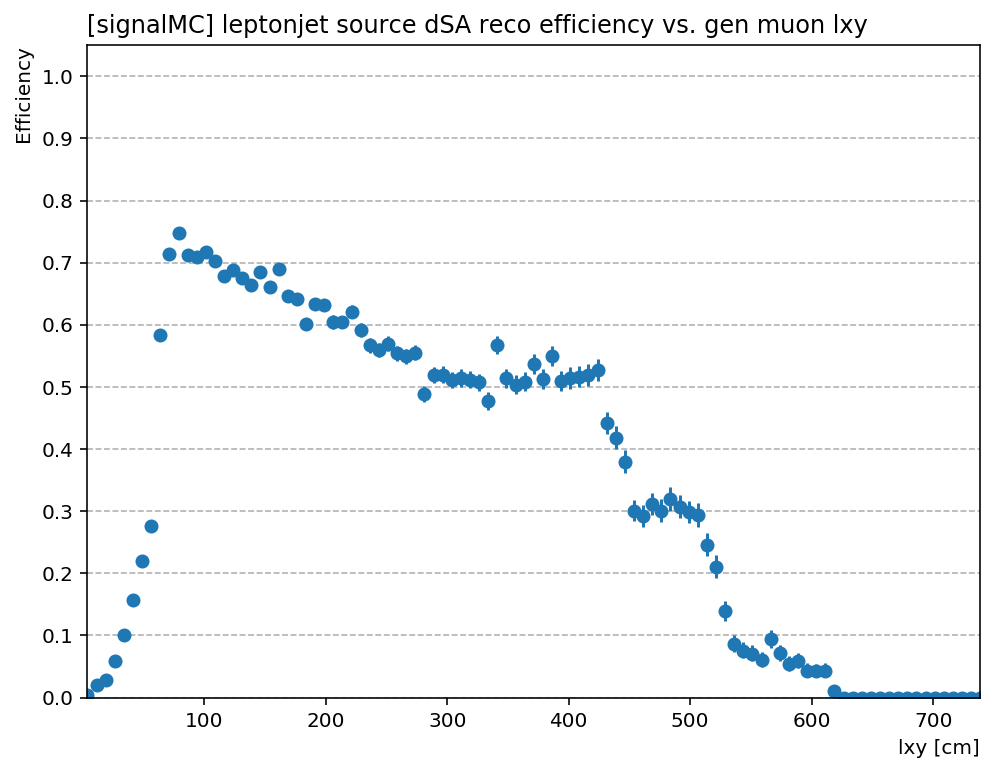

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] leptonjet source dSA reco efficiency vs. gen muon lxy', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

In [18]:
class ljsrcDsaEfficiencyWithTrigger(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        trigger=np.logical_or.reduce([df[t] for t in Triggers])
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            vx=df['gen_vtx.fCoordinates.fX'].content,
            vy=df['gen_vtx.fCoordinates.fY'].content,
            vz=df['gen_vtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(rho=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.pt>25)&(np.abs(genparticles.eta)<2)&(genparticles.rho<750)]
        
        ## at least 2 good gen muons
        nmuGe2 = genmuons.counts>=2
        genmuons = genmuons[nmuGe2&trigger]
        
        ljsrcs = JaggedCandidateArray.candidatesfromcounts(
            df['ljsource_p4'],
            px=df['ljsource_p4.fCoordinates.fX'].content,
            py=df['ljsource_p4.fCoordinates.fY'].content,
            pz=df['ljsource_p4.fCoordinates.fZ'].content,
            energy=df['ljsource_p4.fCoordinates.fT'].content,
            pid=df['ljsource_type'].content,
        )
        ljsrcmu = ljsrcs[(ljsrcs.pid==8)]
        ljsrcmu = ljsrcmu[nmuGe2&trigger]
        
        foundreco = genmuons.match(ljsrcmu, deltaRCut=0.3)
        
        output['lxy'].fill(dataset=dataset, lxy=genmuons[foundreco].rho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=genmuons[~foundreco].rho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [19]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljsrcDsaEfficiencyWithTrigger(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:10<00:00,  9.95items/s]


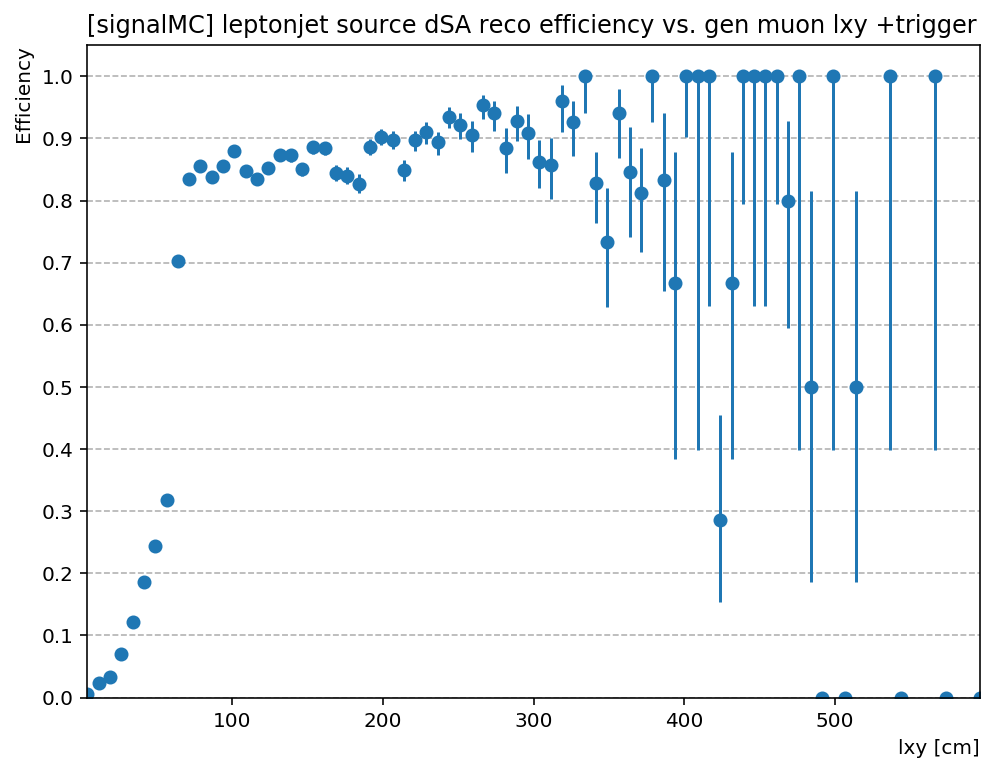

In [20]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] leptonjet source dSA reco efficiency vs. gen muon lxy +trigger', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

## 3. leptonjetDaughter Mu reco efficiency vs. lxy, gen Mu in acceptance, w/ & w/o trigger requirement

In [21]:
class ljdauEfficiency(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            vx=df['gen_vtx.fCoordinates.fX'].content,
            vy=df['gen_vtx.fCoordinates.fY'].content,
            vz=df['gen_vtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(rho=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.pt>25)&(np.abs(genparticles.eta)<2)&(genparticles.rho<750)]
        
        ## at least 2 good gen muons
        nmuGe2 = genmuons.counts>=2
        genmuons = genmuons[nmuGe2]
        
        ljdaus = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_pfcands_n'].sum(),
            pt=awkward.fromiter(df['pfjet_pfcand_pt']).content.content,
            eta=awkward.fromiter(df['pfjet_pfcand_eta']).content.content,
            phi=awkward.fromiter(df['pfjet_pfcand_phi']).content.content,
            energy=awkward.fromiter(df['pfjet_pfcand_energy']).content.content,
            pid=awkward.fromiter(df['pfjet_pfcand_type']).content.content,
        )
        ljdaumu = ljdaus[(ljdaus.pid==3)|(ljdaus.pid==8)]
        ljdaumu = ljdaumu[nmuGe2]
        
        foundreco = genmuons.match(ljdaumu, deltaRCut=0.4)
        
        output['lxy'].fill(dataset=dataset, lxy=genmuons[foundreco].rho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=genmuons[~foundreco].rho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [22]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljdauEfficiency(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:17<00:00,  3.53items/s]


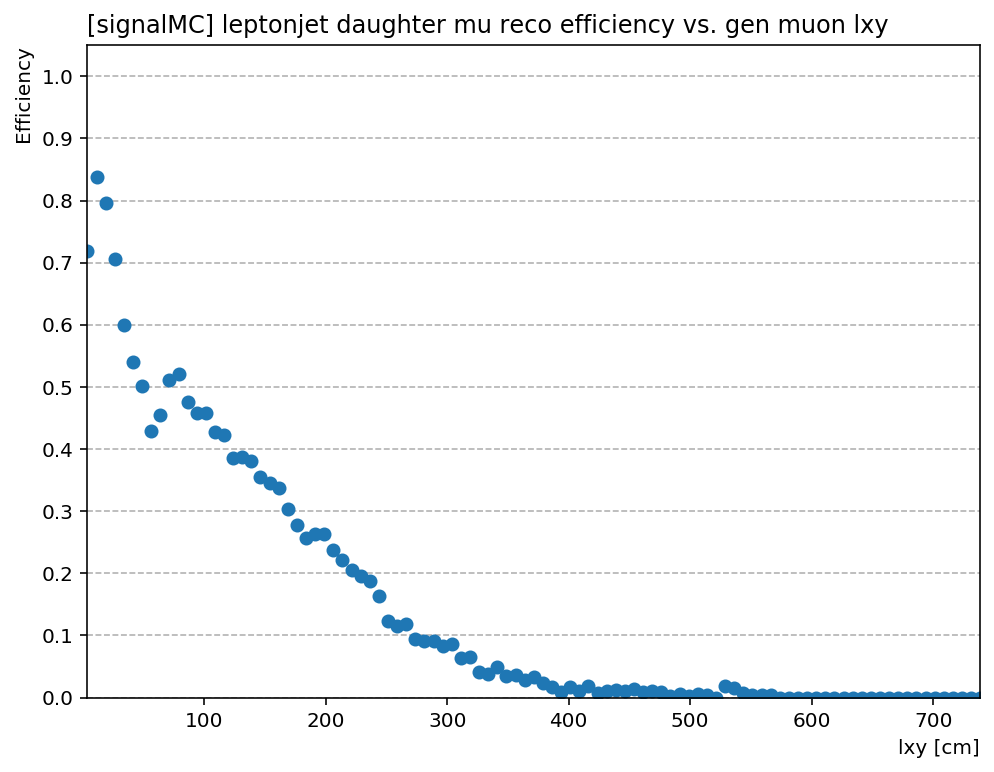

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] leptonjet daughter mu reco efficiency vs. gen muon lxy', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

In [24]:
class ljdauEfficiencyWithTrigger(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        trigger=np.logical_or.reduce([df[t] for t in Triggers])
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            vx=df['gen_vtx.fCoordinates.fX'].content,
            vy=df['gen_vtx.fCoordinates.fY'].content,
            vz=df['gen_vtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(rho=np.hypot(genparticles.vx, genparticles.vy))
        genmuons = genparticles[(np.abs(genparticles.pid)==13)&(genparticles.pt>25)&(np.abs(genparticles.eta)<2)&(genparticles.rho<750)]
        
        ## at least 2 good gen muons
        nmuGe2 = genmuons.counts>=2
        genmuons = genmuons[nmuGe2&trigger]
        
        ljdaus = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_pfcands_n'].sum(),
            pt=awkward.fromiter(df['pfjet_pfcand_pt']).content.content,
            eta=awkward.fromiter(df['pfjet_pfcand_eta']).content.content,
            phi=awkward.fromiter(df['pfjet_pfcand_phi']).content.content,
            energy=awkward.fromiter(df['pfjet_pfcand_energy']).content.content,
            pid=awkward.fromiter(df['pfjet_pfcand_type']).content.content,
        )
        ljdaumu = ljdaus[(ljdaus.pid==3)|(ljdaus.pid==8)]
        ljdaumu = ljdaumu[nmuGe2&trigger]
        
        foundreco = genmuons.match(ljdaumu, deltaRCut=0.4)
        
        output['lxy'].fill(dataset=dataset, lxy=genmuons[foundreco].rho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=genmuons[~foundreco].rho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [25]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljdauEfficiencyWithTrigger(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:16<00:00,  6.20items/s]


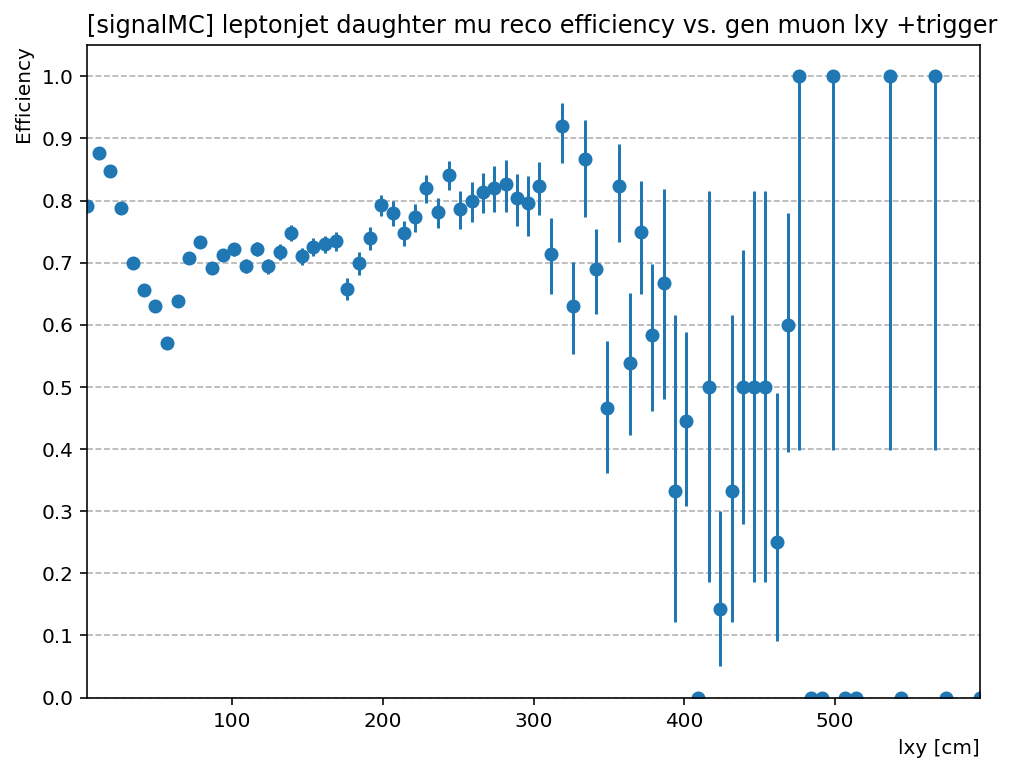

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] leptonjet daughter mu reco efficiency vs. gen muon lxy +trigger', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

## 4. leptonjet vs dark photon lxy, darkphoton in acceptance, w/ & w/o trigger requirements

In [27]:
class ljEfficiency(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            daupid=df['gen_daupid'].content,
            dauvx=df['gen_dauvtx.fCoordinates.fX'].content,
            dauvy=df['gen_dauvtx.fCoordinates.fY'].content,
            dauvz=df['gen_dauvtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(daurho=np.hypot(genparticles.dauvx, genparticles.dauvy))
        gendps = genparticles[(genparticles.pid==32)&(genparticles.daupid==13)&(genparticles.pt>50)&(np.abs(genparticles.eta)<2)&(genparticles.daurho<750)]
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljmutype = leptonjets[leptonjets.ismutype]
        
        foundreco = gendps.match(ljmutype, deltaRCut=0.4)
        
        output['lxy'].fill(dataset=dataset, lxy=gendps[foundreco].daurho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=gendps[~foundreco].daurho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [28]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljEfficiency(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:11<00:00,  5.47items/s]


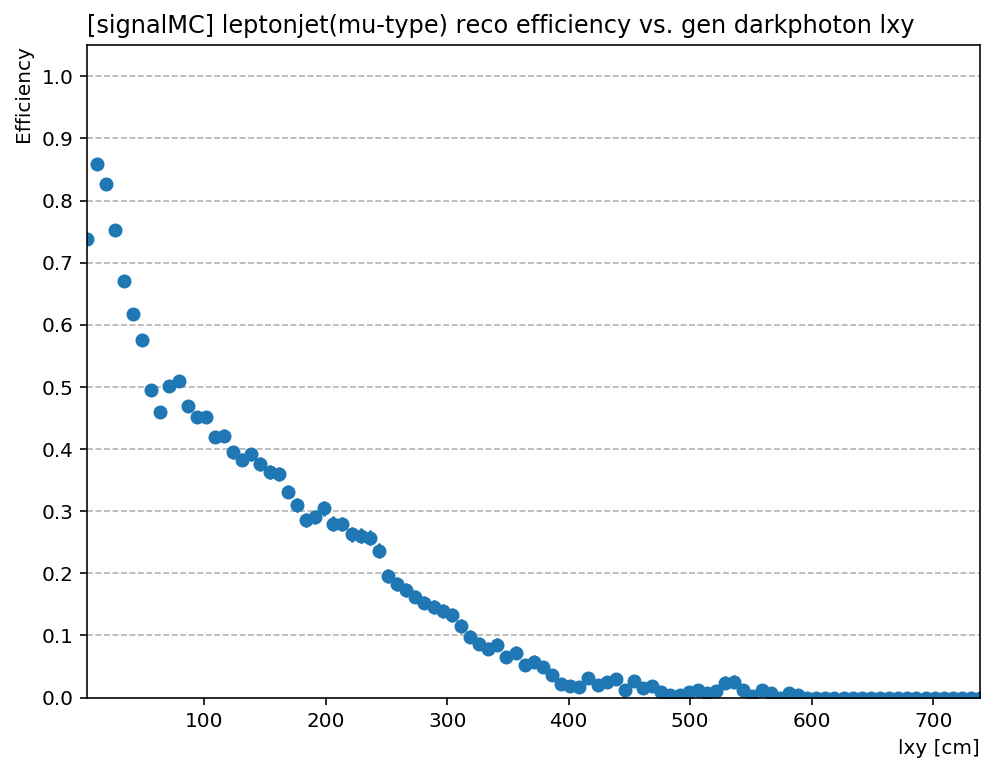

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] leptonjet(mu-type) reco efficiency vs. gen darkphoton lxy', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

In [30]:
class ljEfficiencyWithTrigger(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', 100, 0, 750)
        reco_axis = hist.Cat('reco', 'reco-found')
        self._accumulator = processor.dict_accumulator({
            'lxy': hist.Hist('Counts', dataset_axis, lxy_axis, reco_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        trigger=np.logical_or.reduce([df[t] for t in Triggers])
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            daupid=df['gen_daupid'].content,
            dauvx=df['gen_dauvtx.fCoordinates.fX'].content,
            dauvy=df['gen_dauvtx.fCoordinates.fY'].content,
            dauvz=df['gen_dauvtx.fCoordinates.fZ'].content,
        )
        genparticles.add_attributes(daurho=np.hypot(genparticles.dauvx, genparticles.dauvy))
        gendps = genparticles[(genparticles.pid==32)&(genparticles.daupid==13)&(genparticles.pt>50)&(np.abs(genparticles.eta)<2)&(genparticles.daurho<750)]
        gendps = gendps[trigger]
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljmutype = leptonjets[leptonjets.ismutype]
        ljmutype = ljmutype[trigger]
        
        foundreco = gendps.match(ljmutype, deltaRCut=0.4)
        
        output['lxy'].fill(dataset=dataset, lxy=gendps[foundreco].daurho.flatten(), reco='true')
        output['lxy'].fill(dataset=dataset, lxy=gendps[~foundreco].daurho.flatten(), reco='false')
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [31]:
output = processor.run_uproot_job(datasets_2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljEfficiencyWithTrigger(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:12<00:00,  8.30items/s]


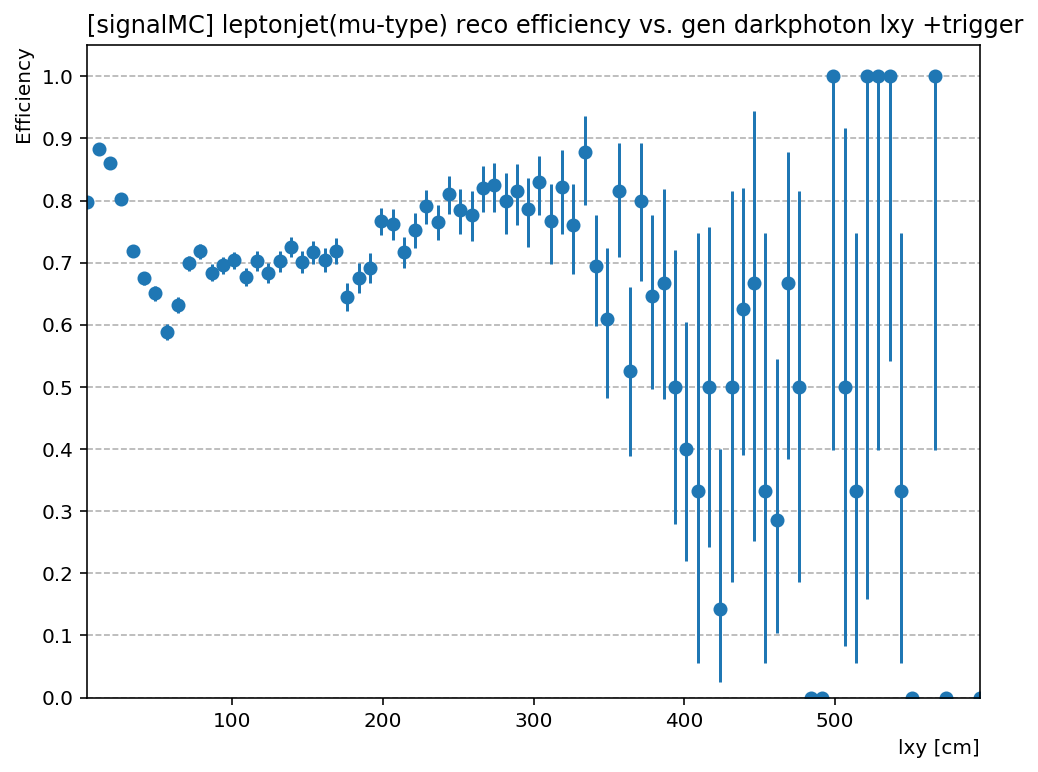

In [32]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['lxy'].sum('dataset').integrate('reco', 'true'),
               denom=output['lxy'].sum('dataset').sum('reco'),
               overflow='over',
               error_opts={'marker': 'o',},
               ax=ax,
              )
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] leptonjet(mu-type) reco efficiency vs. gen darkphoton lxy +trigger', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");